In [1]:
from __future__ import absolute_import, division, print_function

import collections
import functools
import os
import six
import time
import glob
from datetime import datetime
import pickle

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import datetime

# Process Results

## Load DFL files

In [52]:
path = 'results/mixed_K60/DFL_history*'

results_DFL = {}
exp_DFL = []

for filename in glob.iglob(path): 
    print(filename)
    
    exp_id = filename[-6:]
    exp_DFL.append(exp_id)
    
    results_DFL.update({exp_id : {'history' : [] , 'summary' : []}})
    
    filehandler = open(filename, 'rb') 
    results_DFL[exp_id]['history'] = pickle.load(filehandler)
    filehandler.close()
    
    filename = filename.replace("history", "summary")
    if os.path.isfile(filename):
        filehandler = open(filename, 'rb')
        results_DFL[exp_id]['summary'] = pickle.load(filehandler)  
        filehandler.close()


results/mixed_K60/DFL_history_014539_0.2_60_20200224-234711
results/mixed_K60/DFL_history_014539_0.6_60_20200224-182824
results/mixed_K60/DFL_history_014539_0.2_20_20200223-182348
results/mixed_K60/DFL_history_014539_0.6_20_20200225-210010


## Load FL files

In [53]:
path = 'results/mixed_K60/FL_history*'

results_FL = {}
exp_FL = []

for filename in glob.iglob(path): 
    print(filename)
    
    exp_id = filename[-6:]
    exp_FL.append(exp_id)
    
    results_FL.update({exp_id : {'history' : [] , 'summary' : []}})
    
    filehandler = open(filename, 'rb') 
    results_FL[exp_id]['history'] = pickle.load(filehandler)
    filehandler.close()
    
    filename = filename.replace("history", "summary")
    if os.path.isfile(filename):
        filehandler = open(filename, 'rb')
        results_FL[exp_id]['summary'] = pickle.load(filehandler)  
        filehandler.close()

results/mixed_K60/FL_history_014539_0.2_60_20200225-020906
results/mixed_K60/FL_history_014539_0.6_60_20200224-182115
results/mixed_K60/FL_history_014539_0.6_20_20200225-181626


## Load Centralized files

In [54]:
path = 'results/mixed_K60/Centralized*'

results_C = {}
exp_C = []

for filename in glob.iglob(path): 
    
    print(filename)
    exp_id = filename[-6:]
    exp_C.append(exp_id)
    
    results_C.update({exp_id : []})
    
    filehandler = open(filename, 'rb') 
    results_C[exp_id] = pickle.load(filehandler)
    filehandler.close()

results/mixed_K60/Centralized_014539_0.6_20_20200225-214032
results/mixed_K60/Centralized_014539_0.6_60_20200224-184217
results/mixed_K60/Centralized_014539_0.2_20_20200223-202413
results/mixed_K60/Centralized_014539_0.2_60_20200225-003808


In [55]:
exp_C = ['202413'] #['024533','212057', '123319', '213836']
exp_DFL = ['182348'] #['023043', '185834', '114629', '210241']
exp_FL = ['']#['025852', '200057', '101722', '222709']

In [7]:
print(exp_DFL)
print(exp_C)
print(exp_FL)

['144919', '154227', '210831', '224623']
['145950', '154610', '215026', '230031']
['170218', '174141', '194302', '203618']


In [32]:
exp_C[2] = '003808'
exp_FL = ['182115','181626','020906']

## Validation Loss

In [57]:
def get_average_loss(history):
    for exp in history.keys():
        avg_val_loss = np.zeros(len(history[exp]))
        for round_num in range(1, len(history[exp])+1):
            count = 0.
            sum_loss = 0.
            for robot in history[exp].keys():
                if (robot in history[exp][round_num].keys()):
                    num_samples = history[exp][round_num][robot]['num_samples']
                    count += num_samples
                    sum_loss += num_samples * history[exp][round_num][robot]['losses']['val_loss'][0]
            if(count != 0):
                avg_val_loss[round_num - 1] = sum_loss/count
    return avg_val_loss

In [58]:
def get_time_of_round(round_num, summary):
    for exp in summary.keys():
        return summary[exp]['entry_barrier_end'][round_num-1]

In [59]:
def get_time_of_round_FL(round_num, summary):
    for exp in summary.keys():
        return summary[exp]['round_time'][round_num-1]

In [60]:
def get_round_of_convergence(loss, threshold_p=0.1):
    thresh = threshold_p * loss[-1]
    finite_diff = abs(loss - loss[-1])
#     print (list(map(lambda i: i< thresh, finite_diff)).index(True))
    return list(map(lambda i: i< thresh, finite_diff)).index(True)+1 

KeyError: ''

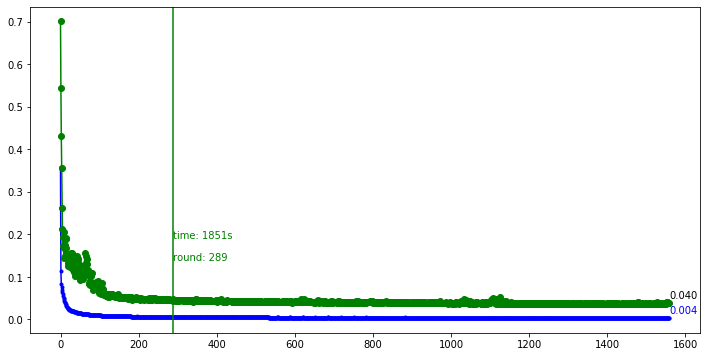

In [61]:
for exp_c, exp_d, exp_f in zip(exp_C, exp_DFL, exp_FL):
    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    # Centralized
    loss_C = results_C[exp_c]['losses']['val_loss']
    plt.plot(loss_C, 'b.-', label='Centralized')
    ax.annotate(format(loss_C[-1], '.3f') , xy= (len(loss_C), loss_C[-1] + 0.01), color='b')
    
    # DFL
    loss_DFL = get_average_loss(results_DFL[exp_d]['history'])
    plt.plot(loss_DFL, 'go-', label='DFL')
    ax.annotate(format(loss_DFL[-1], '.3f') , xy= (len(loss_DFL), loss_DFL[-1] + 0.01))
    if len(results_DFL[exp_d]['summary']) != 0:
        conv_round = get_round_of_convergence(loss_DFL)
        t_conv = get_time_of_round(conv_round, results_DFL[exp_d]['summary'])
        plt.axvline(x=conv_round, color='g')
        ax.annotate("time: " + format(t_conv/10, '.0f') + "s", xy= (conv_round +0.2, loss_DFL[-1] + 0.15), color='g')
        ax.annotate("round: " + format(conv_round, '.0f') , xy= (conv_round +0.2, loss_DFL[-1] + 0.1), color='g')
        
    # FL
    loss_FL = get_average_loss(results_FL[exp_f]['history'])
    plt.plot(loss_FL, 'r-.', label='FL')
    ax.annotate(format(loss_FL[-1], '.3f') , xy= (len(loss_FL), loss_FL[-1] + 0.03), color='r')
    if len(results_FL[exp_f]['summary']) != 0:
        conv_round = get_round_of_convergence(loss_FL)
#         print(results_FL[exp_f]['summary'])
        plt.axvline(x=conv_round, color='r')
        if 'round_time' in results_FL[exp_f]['summary']:
            t_conv = get_time_of_round_FL(conv_round, results_FL[exp_f]['summary'])
            ax.annotate("time: " + format(t_conv/10, '.0f') + "s", xy= (conv_round +0.2, loss_FL[-1] + 0.1))
        ax.annotate("round: " + format(conv_round, '.0f') , xy= (conv_round +0.2, loss_FL[-1] + 0.2), color = 'r')
        
    print(exp_c)
#     plt.plot(avg_val_loss[avg_val_loss!=0], 'r*-', label='FA')
    plt.legend(loc='upper right', fontsize=16)
    plt.xlabel('Epochs (Iterations or Communication rounds)', FontSize=16)
    plt.ylabel('Validation Loss', FontSize=16)

## Inter-epoch time

In [45]:
def get_timing(history, summary):
    for exp in history.keys():
        timings = np.zeros((len(history[exp]), 4))
        # timings[r] = [entry_b_start, entry_b_end, training_min_duration, exit_b_end]
        for round_num in range(1, len(history[exp])+1):
            #print(summary[exp])
            ebs = 0#summary[exp]['entry_barrier_start'][round_num-1]
            ebe = summary[exp]['entry_barrier_end'][round_num-1]
            exbe = summary[exp]['exit_barrier_end'][round_num-1]
            durations = []
            for robot in history[exp].keys():
                if (robot in history[exp][round_num].keys()):
                    durations.append(history[exp][round_num][robot]['time'])
            exbs = min(durations) + ebe
            timings[round_num-1] = [ebs, ebe, exbs, exbs]
    return timings

023043
185834
114629


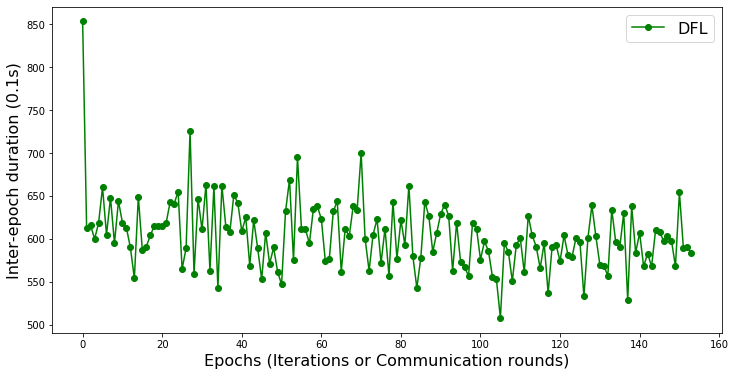

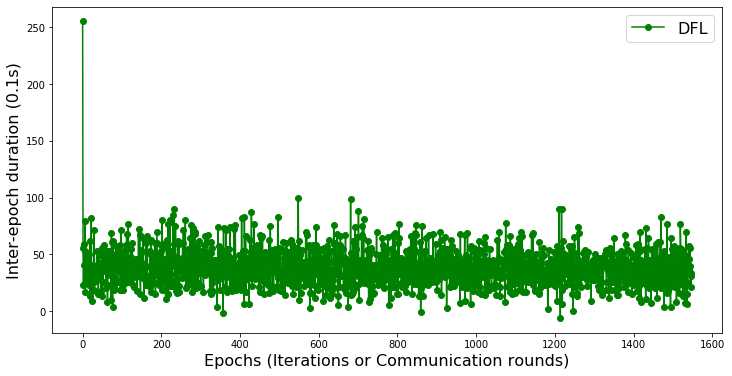

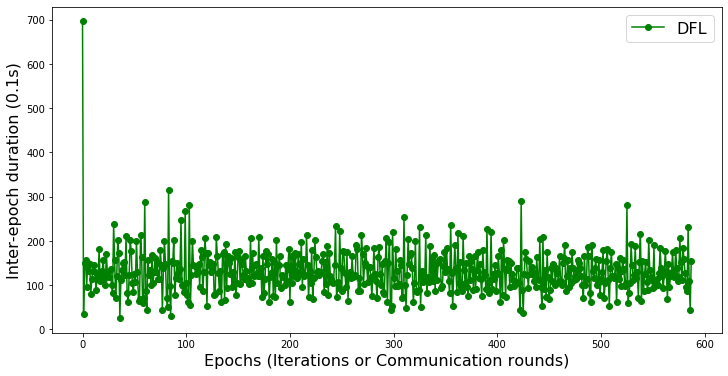

In [46]:
for exp_d, exp_f in zip(exp_DFL, exp_FL):
    if len(results_DFL[exp_d]['summary']) != 0:
        fig = plt.figure(figsize=(12, 6))
        ax = plt.gca()
        timings_DFL = get_timing(results_DFL[exp_d]['history'], results_DFL[exp_d]['summary'])
        inter_epoch = np.zeros(len(timings_DFL)-1)
        inter_epoch[0] = timings_DFL[0][1]
        for i in range(1, len(timings_DFL)-1):
            inter_epoch[i] = timings_DFL[i+1][1] - timings_DFL[i][2]
        plt.plot(inter_epoch, 'go-', label='DFL')
        print(exp_d)
    #     plt.plot(avg_val_loss[avg_val_loss!=0], 'r*-', label='FA')

    if 'round_time' in results_FL[exp_f]['summary']:
        inter_epoch = np.diff(results_FL[exp_f]['summary']['round_time'])
        plt.plot(inter_epoch, 'r-.', label='FL')
    plt.legend(loc='upper right', fontsize=16)
    plt.xlabel('Epochs (Iterations or Communication rounds)', FontSize=16)
    plt.ylabel('Inter-epoch duration (0.1s)', FontSize=16)

## Number of participants

In [47]:
def get_participants(summary):
    for exp in summary.keys():
        num_particip = np.zeros(len(summary[exp]['num_participants']))
        for round_num in range(len(summary[exp]['num_participants'])):
            num_particip[round_num] = summary[exp]['num_participants'][round_num+1]
        return num_particip

023043
185834
114629


AttributeError: 'list' object has no attribute 'keys'

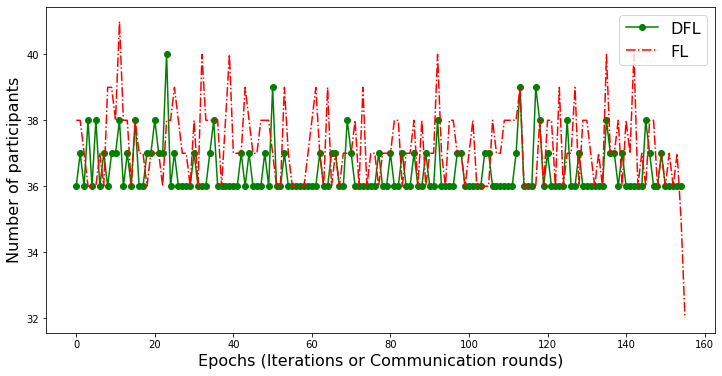

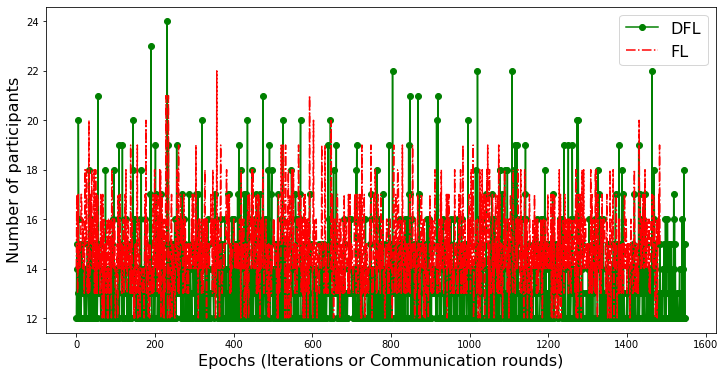

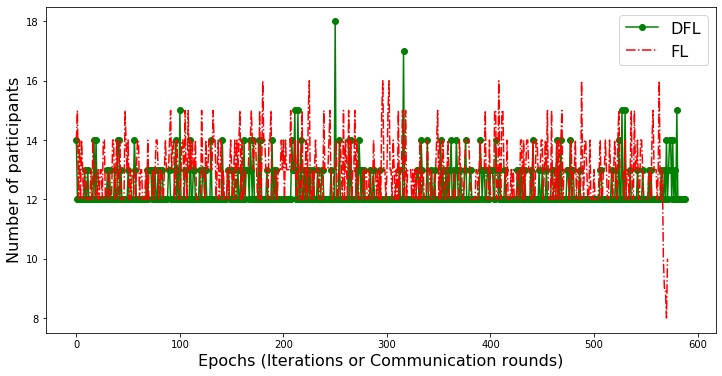

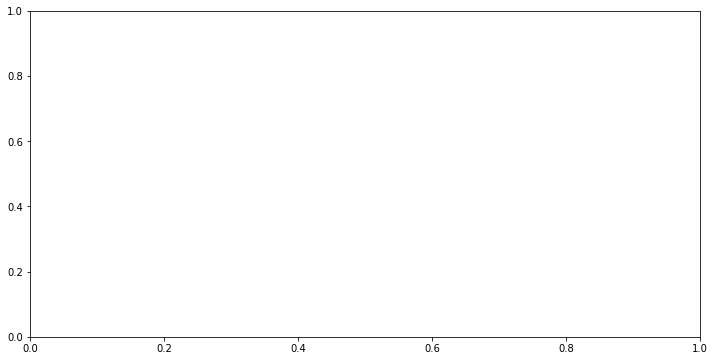

In [51]:
for exp_d, exp_f in zip(exp_DFL, exp_FL):
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    num_p = get_participants(results_DFL[exp_d]['summary'])
    num_p_FL = get_participants(results_FL[exp_f]['summary'])

    plt.plot(num_p, 'go-', label='DFL')
    plt.plot(num_p_FL, 'r-.', label='FL')
    print(exp_d)

    plt.legend(loc='upper right', fontsize=16)
    plt.xlabel('Epochs (Iterations or Communication rounds)', FontSize=16)
    plt.ylabel('Number of participants', FontSize=16)